***Create validation/test datasets***

In [2]:
import os, random, shutil
import kagglehub

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Download latest version

path = kagglehub.dataset_download("obulisainaren/multi-cancer")
ds_path = os.path.join(path, 'Multi Cancer', 'Multi Cancer', 'Cervical Cancer')

if not os.path.exists('./datasets'):
  os.mkdir('./datasets')
if not os.path.exists('./datasets/train'):
  os.mkdir('./datasets/train')
if not os.path.exists('./datasets/test'):
  os.mkdir('./datasets/test')
if not os.path.exists('./datasets/validate'):
  os.mkdir('./datasets/validate')

train_dataset = './datasets/train'
test_dataset = './datasets/test'
validate_dataset = './datasets/validate'

Using Colab cache for faster access to the 'multi-cancer' dataset.


In [5]:
# Copy the original data into test, train, and validate folders

'''
path_datasets = 'datasets/original_data'
train_dataset = './datasets/train'
test_dataset = './datasets/test'
validate_dataset = './datasets/validate'
'''

# Code for google colab
path_datasets = ds_path

split= 0.7

data_dirs = [
    'cervix_dyk',
    'cervix_koc',
    'cervix_mep',
    'cervix_pab',
    'cervix_sfi',
]

for cervix_ds in data_dirs:
    # Check to see if files have already been copied
    if len(os.listdir(train_dataset)) == 5:
        break

    path_cervix_ds = os.path.join(path_datasets, cervix_ds)
    files = [
        f for f in os.listdir(path_cervix_ds)
        if os.path.isfile(os.path.join(path_cervix_ds, f))
    ]

    num_sample = int(len(files) * split)
    training_files = random.sample(files, num_sample)

    for source_file in training_files:
        source_file_path = os.path.join(path_cervix_ds, source_file)
        destination_dir = os.path.join(train_dataset, cervix_ds)

        if not os.path.exists(destination_dir):
            os.makedirs(destination_dir)

        shutil.copy2(source_file_path, destination_dir)

    files = [
        f for f in os.listdir(path_cervix_ds)
        if f not in training_files
    ]

    num_sample = int(len(files) * 0.5)
    testing_files = random.sample(files, num_sample)

    for source_file in testing_files:
        source_file_path = os.path.join(path_cervix_ds, source_file)
        destination_dir = os.path.join(test_dataset, cervix_ds)

        if not os.path.exists(destination_dir):
            os.makedirs(destination_dir)

        shutil.copy2(source_file_path, destination_dir)

    validation_files = [
        f for f in os.listdir(path_cervix_ds)
        if f not in training_files and f not in testing_files
    ]

    for source_file in validation_files:
        source_file_path = os.path.join(path_cervix_ds, source_file)
        destination_dir = os.path.join(validate_dataset, cervix_ds)

        if not os.path.exists(destination_dir):
            os.makedirs(destination_dir)

        shutil.copy2(source_file_path, destination_dir)

In [ ]:
# Destroy all training, testing, and validation data

'''
shutil.rmtree(train_dataset)
shutil.rmtree(test_dataset)
shutil.rmtree(validate_dataset)

os.makedirs(train_dataset)
os.makedirs(test_dataset)
os.makedirs(validate_dataset)
'''

'\nshutil.rmtree(train_dataset)\nshutil.rmtree(test_dataset)\nshutil.rmtree(validate_dataset)\n\nos.makedirs(train_dataset)\nos.makedirs(test_dataset)\nos.makedirs(validate_dataset)\n'

***Preprocess and Label data***

In [6]:
import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [7]:
cancer_type = ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']

train_dataset_paths = [
    os.path.join(train_dataset, ct) for ct in cancer_type
]

test_dataset_paths = [
    os.path.join(test_dataset, ct) for ct in cancer_type
]

validation_dataset_paths = [
    os.path.join(validate_dataset, ct) for ct in cancer_type
]

# Training data before preprocessing
i = 0
data_bptr = []

for train_dp in train_dataset_paths:
    for img_file in os.listdir(train_dp):
        img = cv2.imread(os.path.join(train_dp, img_file))
        data_bptr.append((img, i))

    i = i + 1

# Test data before preprocessing
i = 0
data_bpt = []

for test_dp in test_dataset_paths:
    for img_file in os.listdir(test_dp):
        img = cv2.imread(os.path.join(test_dp, img_file))
        data_bpt.append((img,i))

    i = i + 1

# Validation data before preprocessing
i = 0
data_bpv = []

for val_dp in validation_dataset_paths:
    for img_file in os.listdir(val_dp):
        img = cv2.imread(os.path.join(val_dp, img_file))
        data_bpv.append((img,i))

    i = i + 1

In [8]:
# Classes for training, test, and validation data. This is so that we can use useful features
#   (e.g., batching, shuffling) and to easily apply transformations on data
class CancerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        elm = self.transform(self.data[idx])
        label = self.labels[idx]

        return elm, label

In [9]:
# Preprocessed data of Dataset type

# Unpacking each pair of images and labels
# [(img,label),...] --> ((img,...), (label,...)) --> (img,...) and (label,...)
training_data = CancerDataset(*zip(*data_bptr))
test_data = CancerDataset(*zip(*data_bpt))
validation_data = CancerDataset(*zip(*data_bpv))

***Dataloaders***

In [10]:
# Loads 8 training data randomly from training_data
# batch_size of 8 is chosen since image size is 3x512x512 which will be computationally expensive and
#   some GPUs wouldn't be able to handle that much load
training_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)

# There's no need to shuffle the test and validation data
test_dataloader = DataLoader(test_data, batch_size=8)
validation_dataloader = DataLoader(validation_data, batch_size=8)

***CNN Model Building***

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as f

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 1st layer - in: RGB (3 channels), out: 32 channels
        #   ---> 5th layer - in: 215 channels, out: 512 channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)

        # Max pooling and this halves the input size
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layer: output features connected to all input features
        # Input features: 512*16*16 ---> Output features: 5
        self.fc1 = nn.Linear(in_features=512*16*16, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=5)

    def forward(self, x):
        # Pool after every convolution
        x = self.pool(f.relu(self.conv1(x)))
        x = self.pool(f.relu(self.conv2(x)))
        x = self.pool(f.relu(self.conv3(x)))
        x = self.pool(f.relu(self.conv4(x)))
        x = self.pool(f.relu(self.conv5(x)))

        # Flatten output
        x = torch.flatten(x, 1)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = f.relu(self.fc3(x))

        return x

my_model = CNN()

***Importing Model***

In [13]:
import torchvision.models as models

In [14]:
resnet50_cdt = models.resnet50()
resnet50_cdt.fc = nn.Linear(resnet50_cdt.fc.in_features, 5)

***Train Model***

In [15]:
from tqdm import tqdm

In [16]:
# Loss function for multiclass classification
loss_function = nn.CrossEntropyLoss()
# Standard adam optimizer with learning rate of 1e-4
optimizer = torch.optim.Adam(resnet50_cdt.parameters(), lr=1e-4)
optimizer = torch.optim.Adam(my_model.parameters(), lr=1e-4)
# Set device as gpu if it exists
device = "cuda" if torch.cuda.is_available() else "cpu"

def train(num_epochs, model_type):
    model_type.to(device)

    for epoch in range(num_epochs):
        print("Epoch [{}/{}]".format(epoch + 1,num_epochs))

        # Set model to training mode
        model_type.train()
        for (data, labels) in tqdm(training_dataloader):
            # If cuda exists, data will be moved to the GPU memory
            data = data.to(device)
            labels = labels.to(device)
            outputs = model_type(data)

            # Calculate loss
            loss = loss_function(outputs, labels)
            # Set gradient to 0 before backpropagation
            optimizer.zero_grad()
            loss.backward()
            # Update weights
            optimizer.step()

In [ ]:
EPOCHS = 5

train(EPOCHS, resnet50_cdt)

Epoch [1/5]


100%|██████████| 2188/2188 [01:48<00:00, 20.14it/s]


Epoch [2/5]


100%|██████████| 2188/2188 [01:47<00:00, 20.40it/s]


Epoch [3/5]


100%|██████████| 2188/2188 [01:47<00:00, 20.40it/s]


Epoch [4/5]


100%|██████████| 2188/2188 [01:47<00:00, 20.41it/s]


Epoch [5/5]


100%|██████████| 2188/2188 [01:47<00:00, 20.40it/s]


In [ ]:
train(EPOCHS, my_model)

Epoch [1/5]


100%|██████████| 2188/2188 [00:53<00:00, 40.59it/s]


Epoch [2/5]


100%|██████████| 2188/2188 [00:53<00:00, 40.72it/s]


Epoch [3/5]


100%|██████████| 2188/2188 [00:53<00:00, 40.71it/s]


Epoch [4/5]


100%|██████████| 2188/2188 [00:53<00:00, 40.72it/s]


Epoch [5/5]


100%|██████████| 2188/2188 [00:53<00:00, 40.75it/s]


***Evaluate Model***

In [18]:
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassAccuracy

In [17]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 53.9 MB/s eta 0:00:00


In [19]:
def evaluate(model_type):
    # Set model to evaluation mode
    model_type.eval()

    # Precision: How many were positive (correctly identifying cancer type) out of all predicted positives
    # Recall: How many were correctly positive out of all positives
    # Accuracy: How many did the model correctly predict
    precision_metric = MulticlassPrecision(num_classes=5).to(device)
    recall_metric = MulticlassRecall(num_classes=5).to(device)
    accuracy_metric = MulticlassAccuracy(num_classes=5).to(device)

    # Disable gradient tracking
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_type(inputs)

            # Calculate precision, recall, and accuracy as we iterate through the test dataloader
            precision_metric.update(outputs, labels)
            recall_metric.update(outputs, labels)
            accuracy_metric.update(outputs, labels)

    # Compute final precision, recall, and accuracy
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    print("Precision: {}, Recall: {}, Accuracy: {}".format(precision, recall, accuracy))

In [64]:
evaluate(resnet50_cdt)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
evaluate(my_model)

Precision: 0.44700199365615845, Recall: 0.5853333473205566, Accuracy: 0.5853333473205566


***Saving Model***

In [ ]:
torch.save(resnet50_cdt.state_dict(), "./resnet50_cdt.pth")
torch.save(my_model.state_dict(), "./my_model.pth")

In [ ]:
# Save to google drive
torch.save(resnet50_cdt.state_dict(), "/content/drive/MyDrive/resnet50_cdt.pth")
torch.save(my_model.state_dict(), "/content/drive/MyDrive/my_model.pth")

***Loading Model***

In [20]:
# Load resnet50
test_model = models.resnet50(num_classes = 5)
# Load weights into the model
test_model.load_state_dict(torch.load("/content/drive/MyDrive/resnet50_cdt.pth"))
#device = "cuda" if torch.cuda.is_available() else "cpu"
test_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [66]:
test_model.eval()
evaluate(test_model)

Precision: 0.9480578303337097, Recall: 0.9445333480834961, Accuracy: 0.9445333480834961


***Explainable AI***

In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
def show_images(input_img, heatmap):
  f, arr_ax = plt.subplots(2,1)
  arr_ax[0,0].plot(input_img)
  arr_ax[1,0].plot(heatmap)

def convert_to_image(tensor):
  tensor = tensor.permute(1,2,0)
  tensor = tensor * 512
  return tensor.numpy().astype(np.uint8)

In [29]:
def get_heatmap(model, input_tensor, target_layer, label):
  model.eval()

  gradients = []
  activations = []

  def save_gradients(module, grad_input, grad_output):
    gradients.append(grad_output[0])

  def save_activations(module, input, output):
    activations.append(output)

  input_tensor = input_tensor.unsqueeze(0).to(device)
  hook_bwd = target_layer.register_backward_hook(save_gradients)
  hook_fwd = target_layer.register_forward_hook(save_activations)
  pred = model(input_tensor)
  pred[0, label].backward()

  hook_bwd.remove()
  hook_fwd.remove()

  gradients = gradients[0]
  activations = activations[0]

  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim=1).squeeze()
  heatmap = torch.relu(heatmap)
  heatmap = heatmap.detach().cpu().numpy()

  return heatmap

In [30]:
input_tensor, label = validation_data[2]
final_conv_layer = test_model.layer4[-1]

heatmap = get_heatmap(test_model, input_tensor, final_conv_layer, label)

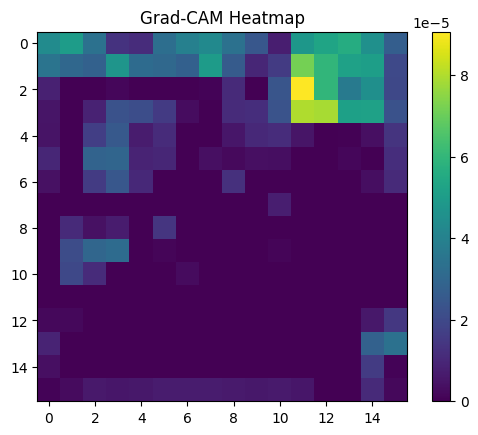

In [31]:
plt.imshow(heatmap)
plt.colorbar()
plt.title("Grad-CAM Heatmap")
plt.show()

In [32]:
def normalize_heatmap(heatmap):
  heatmap = heatmap - heatmap.min()
  heatmap = heatmap / heatmap.max()
  return heatmap

heatmap = normalize_heatmap(heatmap)

In [42]:
def show_heatmap(heatmap):
  c_type = ""
  if(label == 0):
    c_type = "Dyskeratotic"
  elif(label == 1):
    c_type = "Koilocytotic"
  elif(label == 2):
    c_type = "Metaplastic"
  elif(label == 3):
    c_type = "Parabasal"
  else:
    c_type = "Superficial-Intermediate"

  heatmap_norm = heatmap - heatmap.min()
  heatmap_norm = heatmap_norm / heatmap_norm.max()

  heatmap = cv2.resize(
    heatmap_norm,
    (512, 512),
    interpolation=cv2.INTER_CUBIC
  )

  heatmap = cv2.applyColorMap(
    np.uint8(255 * heatmap),
    cv2.COLORMAP_JET
  )
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

  img = (input_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
  img = np.clip(img, 0, 1)

  alpha = 0.4
  overlay = (alpha * heatmap / 255) + ((1 - alpha) * img)
  overlay = np.clip(overlay, 0, 1)

  plt.figure(figsize=(6,6))
  plt.imshow(overlay)
  plt.axis("off")
  plt.colorbar()
  plt.title(f"Cervical Cancer Type: {c_type}")
  plt.show()

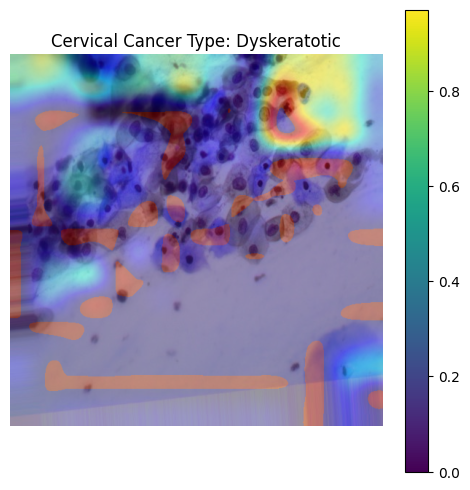

In [38]:
show_heatmap(heatmap)

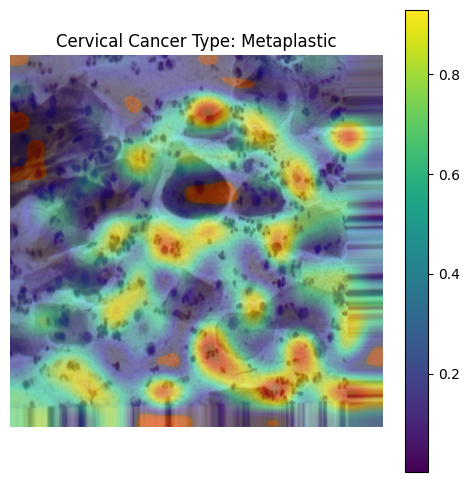

In [41]:
input_tensor, label = validation_data[2000]

show_heatmap(get_heatmap(test_model, input_tensor, test_model.layer4[-1], label))